# Normalización de textos
- Sara Echeverría 21371
- Repositorio: https://github.com/bl33h/textNormalization

In [ ]:
import re
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.metrics.distance import edit_distance
from sklearn.cluster import AgglomerativeClustering
from tokenizers import Tokenizer, models, pre_tokenizers, trainers

In [2]:
nltk.download("punkt", download_dir="nltk_data")

[nltk_data] Downloading package punkt to nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def loadAndStandardize(path):
    with open(path, encoding="utf-8") as file:
        return [re.sub(r"[^\w\s]", "", line.lower()) for line in file if line.strip()]

comments = loadAndStandardize("data/escher_comments.txt")

-> se decidió estandarizar el corpus para facilitar los procesos posteriores de tokenización, comparación y análisis. la estandarización aplicada incluye conversión a minúsculas y eliminación de signos de puntuación.

In [4]:
def trainBpe(comments):
    tokenizer = Tokenizer(models.BPE())
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(special_tokens=["[PAD]", "[UNK]"])
    tokenizer.train_from_iterator(comments, trainer)
    return tokenizer

In [5]:
bpeTokenizer = trainBpe(comments)
bpeTokenizer.encode("es una esfera que refleja").tokens

['es', 'una', 'esfera', 'que', 'refleja']

-> se utilizó la librería `tokenizers` para entrenar un modelo BPE con los tokens especiales `[PAD]` y `[UNK]`. el token `[PAD]` permite igualar la longitud de las secuencias y `[UNK]` se usa para palabras desconocidas.

In [6]:
def trainWordPiece(comments):
    tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.WordPieceTrainer(special_tokens=["[PAD]", "[UNK]"])
    tokenizer.train_from_iterator(comments, trainer)
    return tokenizer

def trainSentencePiece(comments):
    tokenizer = Tokenizer(models.Unigram())
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.UnigramTrainer()
    tokenizer.train_from_iterator(comments, trainer)
    return tokenizer

In [7]:
wordPieceTokenizer = trainWordPiece(comments)
sentencePieceTokenizer = trainSentencePiece(comments)

In [8]:
wordPieceTokenizer.encode("es una esfera que refleja").tokens
sentencePieceTokenizer.encode("es una esfera que refleja").tokens

['es', 'un', 'a', 'es', 'fe', 'ra', 'que', 'refleja']

-> se entrenaron tres modelos: BPE, WordPiece y SentencePiece. todos dividen palabras en subunidades, pero lo hacen con algoritmos distintos. SentencePiece tiende a generar más fragmentos pequeños. la comparación se hizo con la misma frase para observar diferencias.

In [9]:
def stemText(text):
    stemmer = SnowballStemmer("spanish")
    tokens = word_tokenize(text, preserve_line=True)
    return [stemmer.stem(token) for token in tokens]

In [10]:
originalText = comments[0]
stemmedText = stemText(originalText)
originalText, stemmedText

('veo a un hombre explorando su propia percepción al sostener la esfera no solo contempla su reflejo sino que atrapa todo su entorno en un instante de autorreflexión y asombro\n',
 ['veo',
  'a',
  'un',
  'hombr',
  'explor',
  'su',
  'propi',
  'percepcion',
  'al',
  'sosten',
  'la',
  'esfer',
  'no',
  'sol',
  'contempl',
  'su',
  'reflej',
  'sin',
  'que',
  'atrap',
  'tod',
  'su',
  'entorn',
  'en',
  'un',
  'instant',
  'de',
  'autorreflexion',
  'y',
  'asombr'])

-> se utilizó el Snowball Stemmer de NLTK para aplicar stemming en español. este proceso reduce las palabras a su raíz, lo que puede causar pérdida de información semántica, ya que se eliminan variaciones importantes de las palabras.

In [11]:
def computeEditDistanceMatrix(lines):
    size = len(lines)
    matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            matrix[i][j] = edit_distance(lines[i], lines[j])
    return matrix

In [12]:
similarityMatrix = computeEditDistanceMatrix(comments)

-> se construyó una matriz de similitud utilizando la distancia de Levenshtein y se aplicó agrupamiento jerárquico para identificar patrones. los resultados se muestran en un mapa de calor y se interpretan los clústeres a continuación.

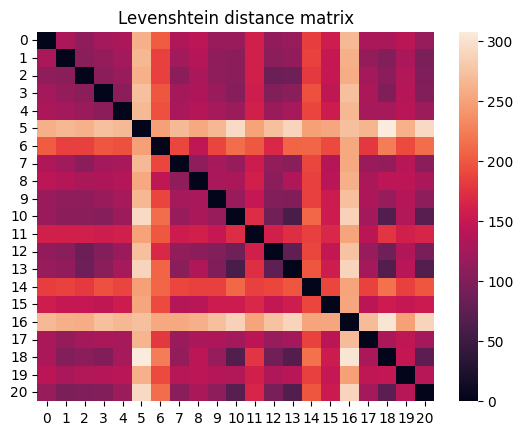

In [13]:
sns.heatmap(similarityMatrix)
plt.title("Levenshtein distance matrix")
plt.show()

In [14]:
clustering = AgglomerativeClustering(n_clusters=4, metric="precomputed", linkage="average")
clusterLabels = clustering.fit_predict(similarityMatrix)
clusterLabels

array([0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
      dtype=int64)

In [15]:
for clusterId in sorted(set(clusterLabels)):
    print(f"\n--- Cluster {clusterId} ---")
    for i, label in enumerate(clusterLabels):
        if label == clusterId:
            print(f"[{i}] {comments[i]}")



--- Cluster 0 ---
[0] veo a un hombre explorando su propia percepción al sostener la esfera no solo contempla su reflejo sino que atrapa todo su entorno en un instante de autorreflexión y asombro

[1] mediante una esfera se refleja la escena y a un hombre que se observa así mismo en el espejo con una sensación de reflexión sobre sí mismo y su alrededor

[2] observo un nombre que sostiene una esfera en la que puede ver su reflejo y el del entorno me evoca un sentimiento de introspección y reflexión personal

[3] me da la sensación de que es la representación del sentimiento de realization es el sentimiento que me provoca muchas veces el reflejo va más allá

[4] veo un entendimiento de perspectiva reflejo y representación de la luz a nivel más analítico veo a un hombre observándose a sí mismo analizando el reflejo de su persona

[7] veo el reflejo de un hombre que sostiene una esfera reflectante entonces podemos observar su habitación con libros muebles etc se ve la distorsión que provo

### Clúster 0
Comentarios descriptivos y reflexivos. Enfocados en el autor, la introspección, el entorno y la representación visual.

### Clúster 1
Un comentario que describe con detalle visual la habitación y la curvatura en el reflejo.

### Clúster 2
Un comentario centrado en la idea del reflejo inevitable de uno mismo y el momento de introspección.

### Clúster 3
Comentario que analiza la percepción subjetiva y las ilusiones provocadas por la forma de la esfera.

## ¿Qué nos dice esto?

El mapa de calor muestra qué comentarios se parecen más entre sí. Las partes oscuras indican que usan palabras similares. Al agruparlos, se encontraron temas comunes. Algunos hablan de reflexión personal, otros describen lo que se ve en la imagen. Esto ayuda a ver cómo las ideas se organizan por el tipo de respuesta.